# Example 4.3: Two-layer feedforward network on California Housing Data

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import numpy as np
import matplotlib.pylab as plt

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection  import train_test_split
from sklearn import preprocessing

## Set the parameters of the network and for learning 

In [2]:
no_features = 8
no_hidden1 = 10
no_hidden2 = 5
no_labels = 1

no_epochs = 50
batch_size = 32
lr = 0.001

SEED = 10
torch.manual_seed(SEED)
np.random.seed(SEED)

## Read and preprocess data

In [3]:
X, y = fetch_california_housing(return_X_y=True)

# Split the data into a training set and a test set
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

scaler = preprocessing.StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

print(x_train.shape)
print(y_test.shape)

(14448, 8)
(6192,)


In [4]:
class MyDataset(Dataset):
  def __init__(self, X, y):
    self.X =torch.tensor(X, dtype=torch.float)
    self.y =torch.tensor(y, dtype=torch.float).unsqueeze(1)
    
  def __len__(self):
    return len(self.y)

  def __getitem__(self,idx):
    return self.X[idx], self.y[idx]

train_data = MyDataset(x_train, y_train)
test_data = MyDataset(x_test, y_test)

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [5]:
# Define the FFN model and learning

In [6]:
class FFN(nn.Module):
    def __init__(self, no_features, no_hidden1, no_hidden2, no_labels):
        super().__init__()
        self.relu_stack = nn.Sequential(
            nn.Linear(no_features, no_hidden1),
            nn.ReLU(),
            nn.Linear(no_hidden1, no_hidden2),
            nn.ReLU(),
            nn.Linear(no_hidden2, no_labels),
        )

    def forward(self, x):
        logits = self.relu_stack(x)
        return logits

In [7]:
def train_loop(train_dataloader, model, loss_fn, optimizer):
    size = len(train_dataloader.dataset)
    num_batches = len(train_dataloader)
    train_loss = 0
    for batch, (X, y) in enumerate(train_dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        train_loss += loss.item()

    train_loss /= size
    return train_loss
    

def test_loop(test_dataloader, model, loss_fn):
    size = len(test_dataloader.dataset)
    num_batches = len(test_dataloader)
    test_loss = 0

    with torch.no_grad():
        for X, y in test_dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

    test_loss /= size
 
    return test_loss
    

In [8]:
model = FFN(no_features, no_hidden1, no_hidden2, no_labels)

print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param} \n")

Model structure: FFN(
  (relu_stack): Sequential(
    (0): Linear(in_features=8, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=5, bias=True)
    (3): ReLU()
    (4): Linear(in_features=5, out_features=1, bias=True)
  )
)


Layer: relu_stack.0.weight | Size: torch.Size([10, 8]) | Values : Parameter containing:
tensor([[-0.0296, -0.0121, -0.1326,  0.0813, -0.2023, -0.0623,  0.1370,  0.3319],
        [ 0.0833, -0.1199,  0.0339, -0.0396,  0.1443,  0.0405,  0.1385,  0.3429],
        [-0.1468, -0.0125,  0.0813, -0.0023, -0.0339, -0.3129, -0.3050, -0.3181],
        [-0.3459, -0.3293, -0.2678, -0.3189, -0.3317,  0.1550,  0.2169,  0.2389],
        [ 0.1905,  0.1198,  0.1558, -0.1955,  0.3183, -0.0244,  0.3050,  0.1084],
        [ 0.2767,  0.2820, -0.0739, -0.1028,  0.0532, -0.0150,  0.0553,  0.1794],
        [-0.2763, -0.0162, -0.2775,  0.3414, -0.2487,  0.0676, -0.0966,  0.2010],
        [ 0.0012, -0.0356,  0.2588,  0.3229, -0.2566, -0.3410,  0.0295, 

## Train the network

In [9]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

train_loss_, test_loss_ = [], []

for epoch in range(no_epochs):
    train_loss = train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loss = test_loop(test_dataloader, model, loss_fn)
    
    train_loss_.append(train_loss)
    test_loss_.append(test_loss)
    
    if epoch%10 == 9:
        print(f"Epoch {epoch+1}, train_loss {train_loss:>7f}  test_loss {test_loss:>7f}")
print("Done!")

Epoch 10, train_loss 0.015158  test_loss 0.016380
Epoch 20, train_loss 0.013654  test_loss 0.015028
Epoch 30, train_loss 0.013167  test_loss 0.014534
Epoch 40, train_loss 0.012896  test_loss 0.014295
Epoch 50, train_loss 0.012755  test_loss 0.014085
Done!


## Print final errors

In [10]:
w1 = model.state_dict()['relu_stack.0.weight'].numpy()
b1 = model.state_dict()['relu_stack.0.bias'].numpy()

w2 = model.state_dict()['relu_stack.2.weight'].numpy()
b2 = model.state_dict()['relu_stack.2.bias'].numpy()

w3 = model.state_dict()['relu_stack.4.weight'].numpy()
b3 = model.state_dict()['relu_stack.4.bias'].numpy()

print('weight = {}, \nbias = {}\n'.format(w1, b1))
print('weight = {}, \nbias = {}\n'.format(w2, b2))
print('weight = {}, \nbias = {}\n'.format(w3, b3))

weight = [[-0.01821475 -0.01314388 -0.12135481  0.08972935 -0.1873828  -0.0596085
   0.13020307  0.34450194]
 [ 0.15020901 -0.16776319  0.0828004  -0.04374294  0.09693841  0.01838458
   0.14542408  0.24602795]
 [ 0.14360383  0.05274698 -0.1998163   0.15692127  0.0038887  -0.96677554
  -0.7002282  -0.61722153]
 [-0.38876897 -0.11807036 -0.18193847 -0.3844353  -0.32696077  0.19438832
   0.21885374  0.23733203]
 [ 0.29796293  0.12437645  0.16083927 -0.17189418  0.2894916  -0.0473719
   0.24448122  0.07250947]
 [ 0.506232    0.25678405  0.02230169  0.00869038  0.09286993 -0.24154128
  -0.03135002 -0.10782546]
 [-0.251643   -0.02300065 -0.29395965  0.33606923 -0.24286519  0.05827786
  -0.12518695  0.21026848]
 [ 0.32045186 -0.10675815  0.07535328 -0.0692523  -0.14331277 -0.5531835
  -0.06160391 -0.07972028]
 [ 0.16339928  0.30172125  0.1418692  -0.16763224 -0.25848797  0.26943082
   0.34057721 -0.13373189]
 [-0.21825618  0.1240752  -0.25478473 -0.08517823 -0.34861028  0.09451437
  -0.130743

## Plot learning curves

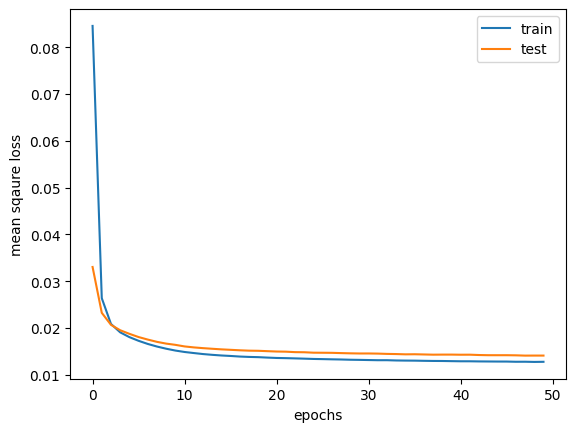

In [11]:
# plot learning curves
plt.figure(1)
plt.plot(range(no_epochs), train_loss_, label='train')
plt.plot(range(no_epochs), test_loss_, label = "test")
plt.xlabel('epochs')
plt.ylabel('mean sqaure loss')
plt.legend()